# Work in Progress

# Load Libraries and Dataset

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [286]:
data = pd.read_csv('garments_worker_productivity.csv')
print(data.shape)
data.head(3)

(1197, 15)


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570


In [256]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

# EDA

1. Quater to categorical dtypes
2. Rename Department wrong typo's and set to categorical dtype (nominal) 
3. Day to categorical dtypes
4. WIP impute NaN with NOCB/LOCF method
5. Removing Highly Missing Data (60% and up)(Large frequency of zeros can't give us useful information)
6. Checking for duplicate entries

#### 1. Quater to categorical dtypes

In [257]:
data.quarter.value_counts()

Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: quarter, dtype: int64

In [258]:
quarter_order = ['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5' ]
data.quarter = pd.Categorical(data.quarter, quarter_order, ordered=True)
# verify quarter order
data.quarter.unique()

['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5']
Categories (5, object): ['Quarter1' < 'Quarter2' < 'Quarter3' < 'Quarter4' < 'Quarter5']

#### 2. Rename department wrong typo's and convert to categorical dtypes

In [259]:
data.department.value_counts()

sweing        691
finishing     257
finishing     249
Name: department, dtype: int64

In [260]:
data['department'] = data['department'].replace(['sweing'], 'sewing')
data['department'] = data['department'].replace(['finishing '], 'finishing')
data.department.value_counts()

sewing       691
finishing    506
Name: department, dtype: int64

In [261]:
data['department'] = data.department.astype('category')
data.department.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1197 entries, 0 to 1196
Series name: department
Non-Null Count  Dtype   
--------------  -----   
1197 non-null   category
dtypes: category(1)
memory usage: 1.4 KB


#### 3. Day to categorical dtypes

In [262]:
data.day.unique()

array(['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday'],
      dtype=object)

In [263]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday' ]
data.day = pd.Categorical(data.day, day_order, ordered=True)
# verify day order
data.day.unique()

['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']
Categories (6, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Saturday' < 'Sunday']

#### 4. WIP impute NaN with NOCB/LOCF method
Usually used when we have more recent data, and we know enough about the past to fill in the blanks. This may need further investigation. Ask how the data is structured/collected. 

In [264]:
data.wip.bfill(axis=0, inplace=True)
# verify
data.tail(6)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
1191,3/11/2015,Quarter2,sewing,Wednesday,7,0.65,30.48,935.0,6840,26,0.0,0,1,57.0,0.650596
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889
1196,3/11/2015,Quarter2,finishing,Wednesday,6,0.70,2.90,NaN,720,0,0.0,0,0,6.0,0.394722


There is still Nan values. Let's use the LOCF (stands for Last Observation Carried Forward)

In [265]:
data.wip.ffill(axis=0, inplace=True)
# verify
data['wip'].isna().sum()

0

#### 5. Removing Highly Missing Data (60% and up) / zero value

In [267]:
# how many zeros are there in each columns?
(data == 0).sum(axis=0) 

date                        0
quarter                     0
department                  0
day                         0
team                        0
targeted_productivity       0
smv                         0
wip                         0
over_time                  31
incentive                 604
idle_time                1179
idle_men                 1179
no_of_style_change       1050
no_of_workers               0
actual_productivity         0
dtype: int64

In [268]:
# proportion zeros in each columns?
(data == 0).sum(axis=0)  / len(data) * 100

date                      0.000000
quarter                   0.000000
department                0.000000
day                       0.000000
team                      0.000000
targeted_productivity     0.000000
smv                       0.000000
wip                       0.000000
over_time                 2.589808
incentive                50.459482
idle_time                98.496241
idle_men                 98.496241
no_of_style_change       87.719298
no_of_workers             0.000000
actual_productivity       0.000000
dtype: float64

In [269]:
# droping columns
data = data.drop(columns=['idle_time', 'idle_men', 'no_of_style_change'])
data.head(2)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sewing,Thursday,8,0.80,26.16,1108.0,7080,98,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,968.0,960,0,8.0,0.886500


#### 6. Duplicates

In [285]:
# variable that store duplicates exactly the same as another row
dups = data.duplicated()
# count duplicates
dups.value_counts()

False    1197
dtype: int64

Our dataset has no duplicates.

#### Final checking

In [271]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   date                   1197 non-null   object  
 1   quarter                1197 non-null   category
 2   department             1197 non-null   category
 3   day                    1197 non-null   category
 4   team                   1197 non-null   int64   
 5   targeted_productivity  1197 non-null   float64 
 6   smv                    1197 non-null   float64 
 7   wip                    1197 non-null   float64 
 8   over_time              1197 non-null   int64   
 9   incentive              1197 non-null   int64   
 10  no_of_workers          1197 non-null   float64 
 11  actual_productivity    1197 non-null   float64 
dtypes: category(3), float64(5), int64(3), object(1)
memory usage: 88.3+ KB


# Statistical Analysis

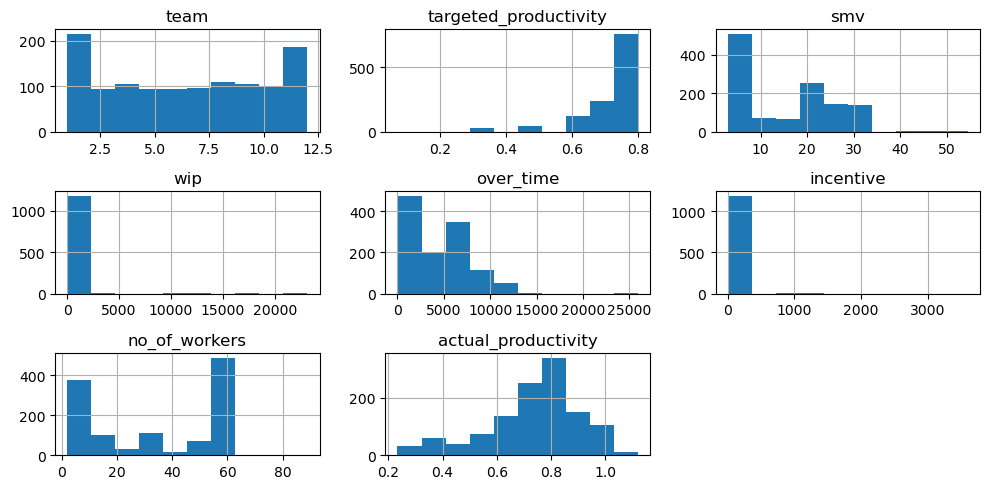

In [276]:
# Univiriate 
data.hist(figsize=(10, 5))
plt.tight_layout()
plt.show()

### Check for skewness
`Important Notes:`
-  between -0.5 and 0.5, the data are fairly symmetrical
-  between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
-  less than -1 or greater than 1, the data are highly skewed

In [319]:
data_int = ['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'no_of_workers', 'actual_productivity']
for i in data_int:
    print(i + ' ==> ' + str(round(data[i].skew(),2)))

team ==> 0.01
targeted_productivity ==> -2.14
smv ==> 0.41
wip ==> 9.74
over_time ==> 0.67
incentive ==> 15.79
no_of_workers ==> -0.11
actual_productivity ==> -0.81


1. `team`s Activity seems fairly distributed
2. `target productivity` Heavily left skewed which is a great. Target productivy must increase overtime.
3. `smv` Distribution is faily symmetrical
4. `wip` Heavily right skewed, as seen in above graph <font color='red'>outliers are affecting the distribution!</font>
5. `over_time` Moderately skewed
6. `incentive` Heavily right skewed. <font color='red'>There must some extremely high incentives!</font>
7. `no_of_worker` Faily distributed
8. `Actual_productiviy` Moderately left skewed. This is a good sign.


## Outliers

In [325]:
#define functions
def showoutliers(df, column_name = ""):
        iqr = df[column_name].quantile(.75) - df[column_name].quantile(.25)
        
        # lower whisker
        lowerbound = (df[column_name].quantile(.25)) - iqr * 1.5 
        # upper whisker
        upperbound = (df[column_name].quantile(.75)) + iqr * 1.5
        
        # datapoints beyond lower whisker
        lowerbound_outliers = df[df[column_name] < lowerbound]
        
        # adtapoint beyond upper whisker
        higherbound_outliers = df[df[column_name] > upperbound]
        
        # outliers
        outliers = pd.concat([lowerbound_outliers,higherbound_outliers])
        return outliers
    
def countoutliers(df, column_name = ""):
        iqr = df[column_name].quantile(.75) - df[column_name].quantile(.25)
        lowerbound = (df[column_name].quantile(.25)) - iqr * 1.5
        upperbound = (df[column_name].quantile(.75)) + iqr * 1.5
        lowerbound_outliers = df[df[column_name] < lowerbound]
        higherbound_outliers = df[df[column_name] > upperbound]
        outliers = pd.concat([lowerbound_outliers,higherbound_outliers])
        count = len(outliers)
        return {column_name : count}
    
def Replace_Outliers(df_name, value, column_name = ""):
    iqr = df_name[column_name].quantile(.75) - df_name[column_name].quantile(.25)
    
    lowerbound = (df_name[column_name].quantile(.25)) - iqr * 1.5
    upperbound = (df_name[column_name].quantile(.75)) + iqr * 1.5
            
    df_name[column_name] = np.where(df_name[column_name] > upperbound, value, df_name[column_name])
    df_name[column_name] = np.where(df_name[column_name] < lowerbound, value, df_name[column_name])

In [333]:
# create a dataset with only numeric values
df_n = data[['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'no_of_workers', 'actual_productivity']]
# df_n

In [335]:
# Count outliers
column_list = df_n.columns
column_list = np.array(column_list)
for i in column_list:
    print (countoutliers(df_n, i))

{'team': 0}
{'targeted_productivity': 79}
{'smv': 0}
{'wip': 22}
{'over_time': 1}
{'incentive': 11}
{'no_of_workers': 0}
{'actual_productivity': 54}


In [336]:
# Proportion outliers
for i in column_list:
    col = i
    perc = countoutliers(df_n, i)[i] / len(df_n)
    print (col + ': ' + str('{:.2f}'.format(perc*100)) + '%') 

team: 0.00%
targeted_productivity: 6.60%
smv: 0.00%
wip: 1.84%
over_time: 0.08%
incentive: 0.92%
no_of_workers: 0.00%
actual_productivity: 4.51%
